In [ ]:
import torch
import time
import os
os.environ["KMP_DUPLICATE_LIB_OK"]='True'
import sys
import random
import cv2
from torchvision.ops import roi_pool
from matplotlib import pyplot as plt
from common.PersonDescriber import PersonDescriber
from common.MOTutils import MOTannotation
from HOG.HogDescriber import HogDescriber_scikit, HogDescriber_torch, HogHyperParams

module_folder_utils = os.path.abspath(os.path.join("..","PeopleDetector", "utils"))
sys.path.insert(0, module_folder_utils)
from datasets import LoadImages



data_folder = os.path.join("..", "inputs", "videos", "512")
video_path = os.path.join(data_folder, "512.mp4")
annotations_path = os.path.join(data_folder, "gt", "gt.txt")
video = LoadImages(video_path,1920)
annotations = MOTannotation(annotations_path)
framerate = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
describer = HogDescriber_torch(HogHyperParams(),device)

#params
target_resolution=(128,64)
frame_stride = 10   #let's try extracting crops every 0.5 seconds

t0 = time.time()

current_frame = -1
for path, img, im0s, vid_cap in video:
    current_frame+=1
    if current_frame % frame_stride != 0:
        continue

    boxes = torch.zeros(size=(0,5),device=device, dtype=torch.float)
    mot_ids = torch.zeros(size=(0,1),device=device, dtype=torch.long)
    target_ids = torch.zeros(size=(0,1),device=device, dtype=torch.long)

    for el in annotations[current_frame+1]: #in annotations frame number are in base 1
        b = torch.Tensor((0,el.bb_left_,el.bb_top_, el.bb_left_ + el.bb_width_, el.bb_top_ + el.bb_height_)).to(dtype=torch.float, device=device).reshape(1,5)
        boxes = torch.cat((boxes,b))    

    frame_tensor = torch.from_numpy(im0s).to(dtype=torch.float, device=device).permute(2,0,1).unsqueeze(0) / 255.0
    crops = roi_pool(frame_tensor,boxes, target_resolution).to(device)

    descriptors = describer.Extract_Description(crops) 

    if current_frame == 0:
        data = descriptors
        #plt.imshow(crops[4].cpu().numpy().transpose(1,2,0))
        #break
    else:
        data = torch.cat((data,descriptors),0)


t1 = time.time()
print(f"finished in {t1-t0}s. data: {data.shape}")
means = torch.mean(data,0)
print(means.shape)
torch.save(means, "means.bin")

centered_data = data - means
sigma = torch.matmul(centered_data.transpose(0,1), centered_data)
torch.save(sigma, "covariances.bin")

inv_sigma = torch.inverse(sigma)
torch.save(inv_sigma,"inv_covariances.bin")
print(inv_sigma.shape)


In [19]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from common.PeopleDB import PeopleDB, L2_distance, Mahalanobis_distance, Cosine_distance
inverse_covs = torch.load(os.path.join("inv_covariances.bin"))

def Mahalanobis_dist(x,y):
    return Mahalanobis_distance(x,y, inverse_covs)

def subplot(descr_x, descr_y, plt_axis, side:int, dist_function, title:str):
    img = np.zeros(shape=(side,side),dtype=np.float32)
    for i in range(side):
        for j in range(side):
            img[i,j] = dist_function(descr_y[i], descr_x[j])
    for k in range(side):
        for j in range(side):
            value = '%.2f' % img[k, j]
            color = 'w' if img[k, j] < 0.3 else 'black'
            text = plt_axis.text(j, k, value,
                        ha="center", va="center", color=color,fontsize=8)
    plt_axis.imshow(img)
    plt_axis.set_title(title)
    return

class FrameData:
    def __init__(self, ids:torch.Tensor, descriptors:torch.Tensor):
        """ids and descriptors tensor must have same,unidimensional shape"""
        self.data_ = {}
        for i in range(ids.shape[0]):
            self.data_[int(ids[i])] = descriptors[i]

    def get_ids(self):
        return self.data_.keys()

    def get_descr(self, id):
        return self.data_[id]    

def plot_differences(x:FrameData, y:FrameData, max_number:int= -1, only_euclidean:bool=False, title:str=""):
    #we want to plot only descriptors referring to the same id in both data structures.
    x_ids = x.get_ids()
    y_ids = y.get_ids()
    common_ids = [i for i in x_ids if i in y_ids]
    #print("common ids:",common_ids)
    if max_number < 0:
        side = len(common_ids)
    else:
        side = min(max_number, len(common_ids))

    descr_x = [x.get_descr(i) for i in common_ids]    
    descr_y = [y.get_descr(i) for i in common_ids]    

    nplots = 1 if only_euclidean else 3
    dim = (8,8) if only_euclidean else (15,5)
    fig, ax = plt.subplots(1,nplots,figsize=dim)
    if title != "":
        fig.suptitle(title)
    if not only_euclidean:
        subplot(descr_x,descr_y,ax[0],side,L2_distance, "Euclidean distance")
        subplot(descr_x,descr_y,ax[1],side,Mahalanobis_dist, "Mahalanobis distance")
        subplot(descr_x,descr_y,ax[2],side,Cosine_distance, "Cosine distance")
    else:
        subplot(descr_x,descr_y,ax,side,L2_distance,"Euclidean distance")

    plt.show()




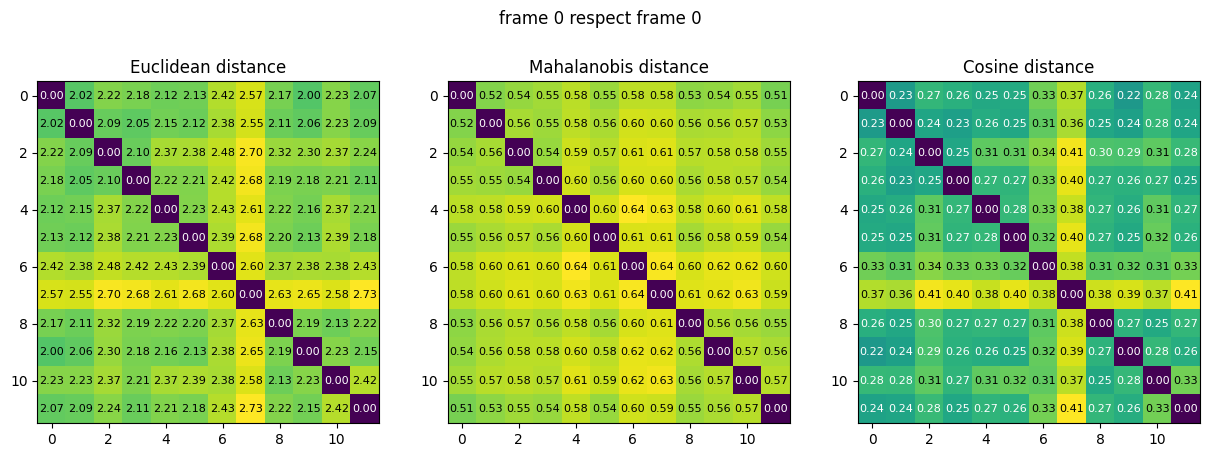

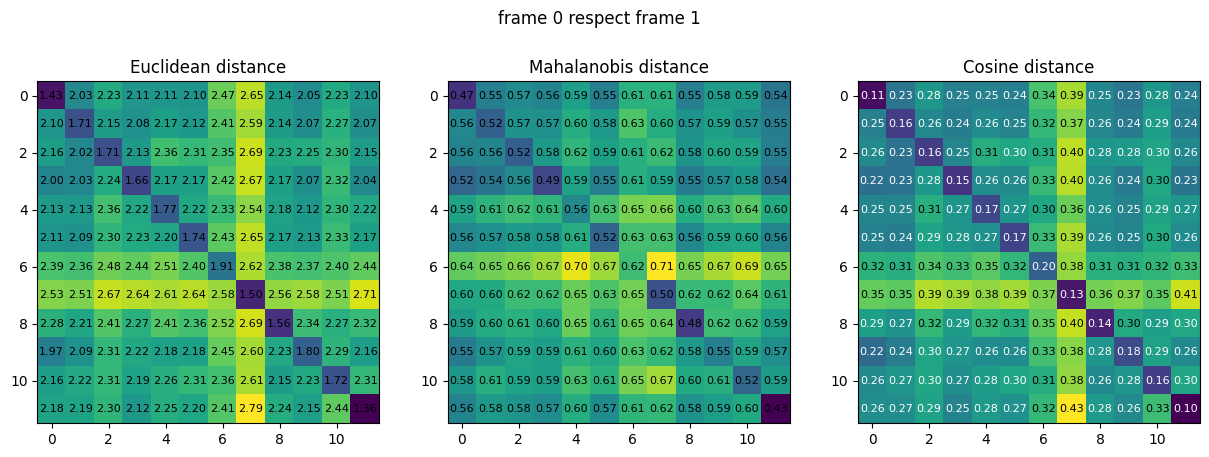

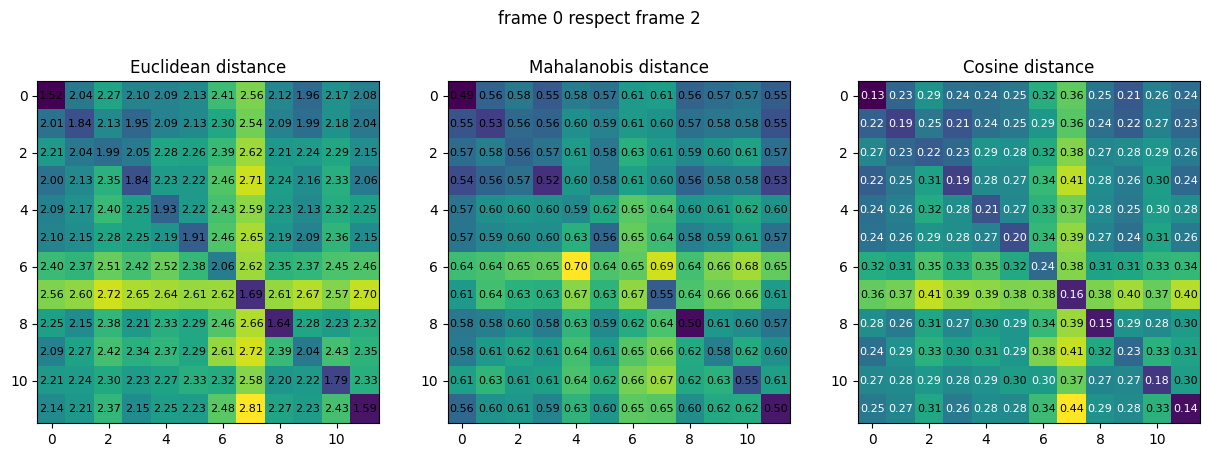

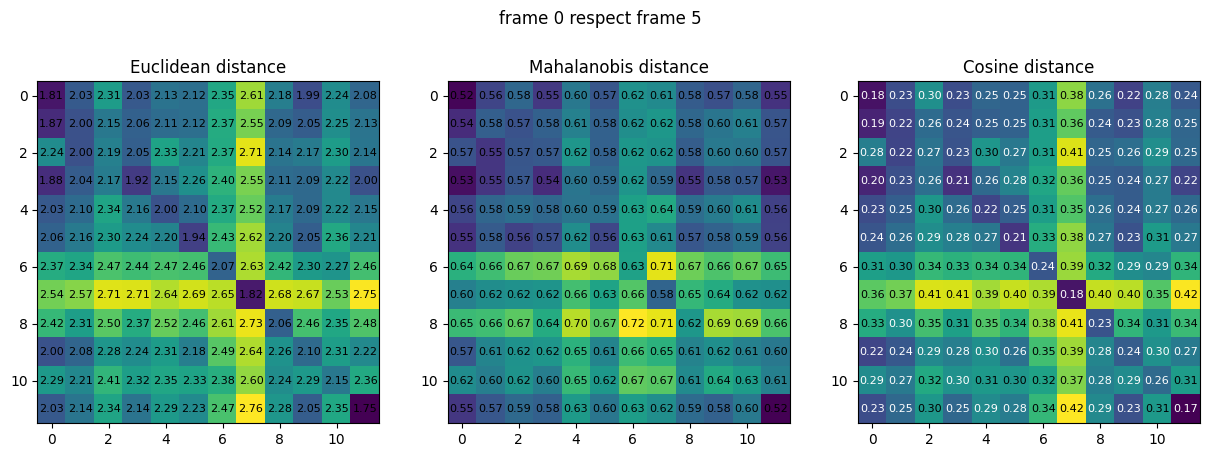

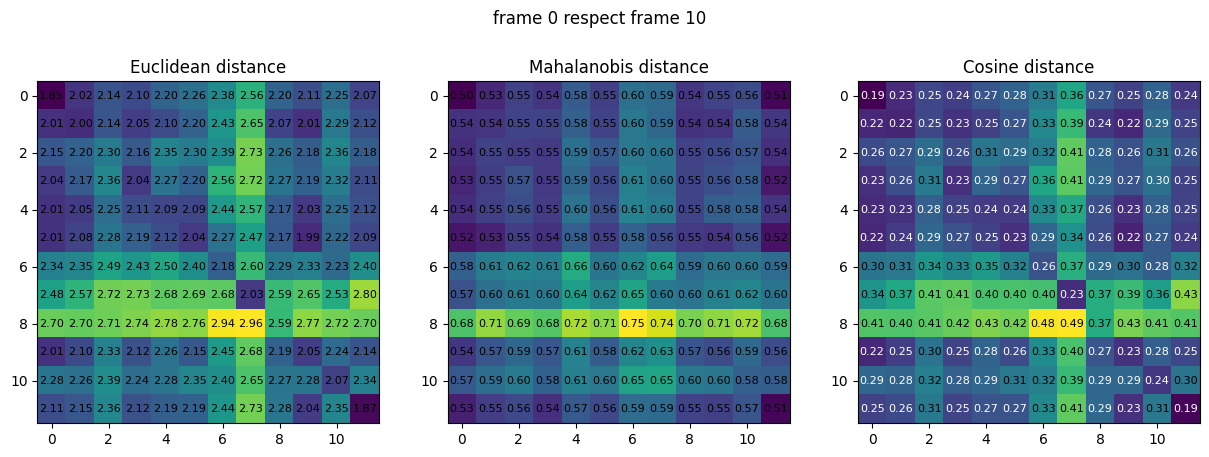

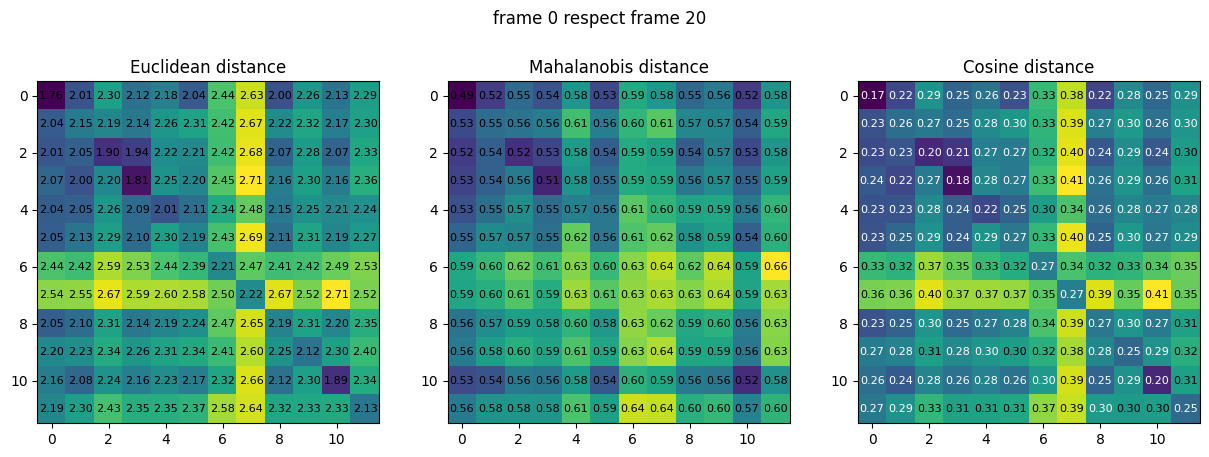

In [21]:
#import torch
import time
import os
os.environ["KMP_DUPLICATE_LIB_OK"]='True'
import sys
import random
import cv2
from torchvision.ops import roi_pool
from matplotlib import pyplot as plt
from common.PersonDescriber import PersonDescriber
from common.MOTutils import MOTannotation
from HOG.HogDescriber import HogDescriber_scikit, HogDescriber_torch, HogHyperParams

module_folder_utils = os.path.abspath(os.path.join("..","PeopleDetector", "utils"))
sys.path.insert(0, module_folder_utils)
from datasets import LoadImages



data_folder = os.path.join("..", "inputs", "videos", "512")
video_path = os.path.join(data_folder, "512.mp4")
annotations_path = os.path.join(data_folder, "gt", "gt.txt")
video = LoadImages(video_path,1920,verbose=False)
annotations = MOTannotation(annotations_path)
framerate = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
describer = HogDescriber_torch(HogHyperParams(),device)

#params
target_resolution=(128,64)



frame_data = []

t0 = time.time()
current_frame = -1
for path, img, im0s, vid_cap in video:
    current_frame+=1

    boxes = torch.zeros(size=(0,5),device=device, dtype=torch.float)
    mot_ids = torch.zeros(size=(0,),device=device, dtype=torch.long)

    frame_annotations = annotations[current_frame+1]  #in annotations frame number are in base 1
    #print(f"annotations in this frame: {len(frame_annotations)}")
    for el in frame_annotations:
        b = torch.Tensor((0,el.bb_left_,el.bb_top_, el.bb_left_ + el.bb_width_, el.bb_top_ + el.bb_height_)).to(dtype=torch.float, device=device).reshape(1,5)
        boxes = torch.cat((boxes,b))
        id =torch.Tensor([el.id_]).to(dtype=torch.long, device=device)
        mot_ids = torch.cat((mot_ids, id))

    frame_tensor = torch.from_numpy(im0s).to(dtype=torch.float, device=device).permute(2,0,1).unsqueeze(0) / 255.0
    crops = roi_pool(frame_tensor, boxes, target_resolution).to(device)

    #print(crops.shape)
    descriptors = describer.Extract_Description(crops,use_colors=False)

    #print(f"descr: {descriptors.shape}")
    frame_data.append(FrameData(mot_ids, descriptors))
    #print(frame_data[current_frame].get_ids())

    if current_frame == 0:
        plot_differences(frame_data[0],frame_data[0],max_number=12,title=f"frame {0} respect frame {0}")
    if current_frame == 1:
        plot_differences(frame_data[0],frame_data[1],max_number=12,title=f"frame {0} respect frame {1}")
    if current_frame == 2:
        plot_differences(frame_data[0],frame_data[2],max_number=12,title=f"frame {0} respect frame {2}")
    if current_frame == 5:
        plot_differences(frame_data[0],frame_data[5],max_number=12,title=f"frame {0} respect frame {5}")
    if current_frame == 10:
        plot_differences(frame_data[0],frame_data[10],max_number=12,title=f"frame {0} respect frame {10}")
    if current_frame == 20:
        plot_differences(frame_data[0],frame_data[20],max_number=12,title=f"frame {0} respect frame {20}")
        break


t1 = time.time()